<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [3]:
# # # Google Colab
# !pip install keras_cv

In [4]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [6]:
# # Google Colab

# # Define the path to the zip file and the extraction folder
# zip_path = Path("../data/rare_species.zip")

# # Get the directory where the zip file is located
# extract_path = Path("../data/rare_species")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [7]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [8]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Feature Engineering 

<div>

In [10]:
#Load the DataFrames from the .pkl files
with open("../data/train_df.pkl", "rb") as f:
     train_df = pickle.load(f)

with open("../data/valid_df.pkl", "rb") as f:
     valid_df = pickle.load(f)

with open("../data/test_df.pkl", "rb") as f:
     test_df = pickle.load(f)

In [11]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [ ]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

2025-04-16 10:27:45.796381: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-16 10:27:45.796534: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-16 10:27:45.796541: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-16 10:27:45.796731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-16 10:27:45.796745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<div class="alert alert-block alert-success">

# **3.** Models

<div>

## ResNet50 - Margarida

In [29]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [30]:
# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment='mixup',
    oversampling=True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [31]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run2.csv",
  lr_scheduler=my_scheduler_fn
)

In [32]:
input_img = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(202, activation='softmax')(x)

# Define final model
model = models.Model(inputs=input_img, outputs=output)

In [33]:
base_model.trainable = False
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=metrics)
history = model.fit(train_ds, epochs=100, batch_size=16, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
193/350 ━━━━━━━━━━━━━━━━━━━━ 1:06 427ms/step - acc: 0.0155 - auc: 0.5240 - f1_score: 0.0090 - loss: 6.6685

KeyboardInterrupt: 

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plot_model_acc(num_epochs=5, train_loss=loss_train, train_val=loss_val)

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
xaxis = range(1,epochs+1)
plt.plot(xaxis, loss_train, 'g', label='Training loss')
plt.plot(xaxis, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

## ResNet50 - Margarida - com preprocessing

### Original

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment='mixup',
    oversampling=True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)


In [ ]:
input_img = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)


In [ ]:
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
     lr_callback]


In [ ]:
# Run the experiment
history = experiment.run_experiment(callbacks=callbacks_additional, epochs=45)

No checkpoint found, starting from scratch.
Epoch 1/45


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
2025-04-15 14:37:26.442752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.0178 - auc: 0.5417 - f1_score: 0.0065 - loss: 6.7131

2025-04-15 14:40:05.381854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


350/350 ━━━━━━━━━━━━━━━━━━━━ 128s 360ms/step


2025-04-15 14:42:14.546893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 315s 890ms/step - accuracy: 0.0178 - auc: 0.5418 - f1_score: 0.0065 - loss: 6.7129 - val_accuracy: 0.1508 - val_auc: 0.7361 - val_f1_score: 0.0304 - val_loss: 4.6915 - learning_rate: 9.5499e-05
Epoch 2/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.0778 - auc: 0.5978 - f1_score: 0.0226 - loss: 6.1840

2025-04-15 14:45:32.217236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 124s 352ms/step


2025-04-15 14:47:36.343399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 321s 917ms/step - accuracy: 0.0778 - auc: 0.5978 - f1_score: 0.0226 - loss: 6.1836 - val_accuracy: 0.2115 - val_auc: 0.7961 - val_f1_score: 0.0555 - val_loss: 4.1443 - learning_rate: 9.1201e-05
Epoch 3/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.1251 - auc: 0.6313 - f1_score: 0.0421 - loss: 5.4236

2025-04-15 14:50:46.188319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 124s 354ms/step


2025-04-15 14:52:51.066035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 316s 903ms/step - accuracy: 0.1251 - auc: 0.6313 - f1_score: 0.0421 - loss: 5.4233 - val_accuracy: 0.2666 - val_auc: 0.8384 - val_f1_score: 0.0938 - val_loss: 3.7317 - learning_rate: 8.7096e-05
Epoch 4/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.1673 - auc: 0.6576 - f1_score: 0.0590 - loss: 4.8822

2025-04-15 14:56:19.691550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 132s 378ms/step


2025-04-15 14:58:32.533944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 342s 977ms/step - accuracy: 0.1673 - auc: 0.6576 - f1_score: 0.0591 - loss: 4.8819 - val_accuracy: 0.3055 - val_auc: 0.8704 - val_f1_score: 0.1291 - val_loss: 3.4103 - learning_rate: 8.3176e-05
Epoch 5/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2107 - auc: 0.6793 - f1_score: 0.0856 - loss: 4.4117

2025-04-15 15:26:37.205711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 107s 306ms/step


2025-04-15 15:28:25.075310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 273ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1790s 5s/step - accuracy: 0.2107 - auc: 0.6793 - f1_score: 0.0856 - loss: 4.4115 - val_accuracy: 0.3472 - val_auc: 0.8861 - val_f1_score: 0.1717 - val_loss: 3.1923 - learning_rate: 7.9433e-05
Epoch 6/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.2523 - auc: 0.6920 - f1_score: 0.1155 - loss: 4.0961

2025-04-15 15:31:17.956941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 122s 347ms/step


2025-04-15 15:33:20.007953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 301ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 297s 849ms/step - accuracy: 0.2524 - auc: 0.6920 - f1_score: 0.1156 - loss: 4.0959 - val_accuracy: 0.3712 - val_auc: 0.8984 - val_f1_score: 0.2008 - val_loss: 3.0175 - learning_rate: 7.5858e-05
Epoch 7/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.2896 - auc: 0.7032 - f1_score: 0.1495 - loss: 3.8432

2025-04-15 15:36:51.034440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 123s 350ms/step


2025-04-15 15:38:54.236307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 260ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 331s 948ms/step - accuracy: 0.2896 - auc: 0.7032 - f1_score: 0.1495 - loss: 3.8431 - val_accuracy: 0.3996 - val_auc: 0.9129 - val_f1_score: 0.2410 - val_loss: 2.8658 - learning_rate: 7.2444e-05
Epoch 8/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.3087 - auc: 0.7175 - f1_score: 0.1699 - loss: 3.6535

2025-04-15 15:41:37.569125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 109s 311ms/step


2025-04-15 15:43:27.219720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 275ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 274s 783ms/step - accuracy: 0.3087 - auc: 0.7175 - f1_score: 0.1700 - loss: 3.6534 - val_accuracy: 0.4207 - val_auc: 0.9185 - val_f1_score: 0.2692 - val_loss: 2.7678 - learning_rate: 6.9183e-05
Epoch 9/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.3352 - auc: 0.7250 - f1_score: 0.1931 - loss: 3.4876

2025-04-15 15:46:33.381689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 116s 330ms/step


2025-04-15 15:48:29.829849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 303s 867ms/step - accuracy: 0.3352 - auc: 0.7250 - f1_score: 0.1931 - loss: 3.4875 - val_accuracy: 0.4446 - val_auc: 0.9249 - val_f1_score: 0.3004 - val_loss: 2.6781 - learning_rate: 6.6069e-05
Epoch 10/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3626 - auc: 0.7304 - f1_score: 0.2264 - loss: 3.3206

2025-04-15 16:11:30.951179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 1174s 3s/step


2025-04-15 16:31:05.277610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 295ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 2557s 7s/step - accuracy: 0.3626 - auc: 0.7305 - f1_score: 0.2265 - loss: 3.3206 - val_accuracy: 0.4585 - val_auc: 0.9300 - val_f1_score: 0.3202 - val_loss: 2.6048 - learning_rate: 6.3096e-05
Epoch 11/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.3797 - auc: 0.7329 - f1_score: 0.2435 - loss: 3.2625

2025-04-15 16:34:03.227916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 121s 345ms/step


2025-04-15 16:36:05.145933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 299s 854ms/step - accuracy: 0.3798 - auc: 0.7329 - f1_score: 0.2435 - loss: 3.2623 - val_accuracy: 0.4630 - val_auc: 0.9338 - val_f1_score: 0.3275 - val_loss: 2.5563 - learning_rate: 6.0256e-05
Epoch 12/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.3951 - auc: 0.7407 - f1_score: 0.2668 - loss: 3.1364

2025-04-15 16:39:04.808274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 124s 354ms/step


2025-04-15 16:41:09.663065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 293ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 305s 870ms/step - accuracy: 0.3951 - auc: 0.7407 - f1_score: 0.2669 - loss: 3.1363 - val_accuracy: 0.4830 - val_auc: 0.9365 - val_f1_score: 0.3447 - val_loss: 2.5037 - learning_rate: 5.7544e-05
Epoch 13/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4043 - auc: 0.7425 - f1_score: 0.2748 - loss: 3.0798

2025-04-15 16:44:15.633340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 123s 348ms/step


2025-04-15 16:46:19.505805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 310s 887ms/step - accuracy: 0.4043 - auc: 0.7425 - f1_score: 0.2748 - loss: 3.0797 - val_accuracy: 0.4886 - val_auc: 0.9406 - val_f1_score: 0.3562 - val_loss: 2.4586 - learning_rate: 5.4954e-05
Epoch 14/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.4245 - auc: 0.7430 - f1_score: 0.2944 - loss: 3.0074

2025-04-15 16:49:33.038620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 131s 374ms/step


2025-04-15 16:51:44.559272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 323s 917ms/step - accuracy: 0.4245 - auc: 0.7430 - f1_score: 0.2945 - loss: 3.0073 - val_accuracy: 0.5003 - val_auc: 0.9438 - val_f1_score: 0.3696 - val_loss: 2.4238 - learning_rate: 5.2481e-05
Epoch 15/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4457 - auc: 0.7474 - f1_score: 0.3100 - loss: 2.9019

2025-04-15 16:54:49.601870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 121s 344ms/step


2025-04-15 16:56:50.861339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 307s 878ms/step - accuracy: 0.4457 - auc: 0.7474 - f1_score: 0.3101 - loss: 2.9019 - val_accuracy: 0.5064 - val_auc: 0.9445 - val_f1_score: 0.3782 - val_loss: 2.3896 - learning_rate: 5.0119e-05
Epoch 16/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.4520 - auc: 0.7514 - f1_score: 0.3275 - loss: 2.8572

2025-04-15 16:59:55.568220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 118s 338ms/step


2025-04-15 17:01:54.637035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 317ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 309s 881ms/step - accuracy: 0.4520 - auc: 0.7514 - f1_score: 0.3275 - loss: 2.8571 - val_accuracy: 0.5086 - val_auc: 0.9438 - val_f1_score: 0.3808 - val_loss: 2.3685 - learning_rate: 4.7863e-05
Epoch 17/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.4559 - auc: 0.7530 - f1_score: 0.3343 - loss: 2.8242

2025-04-15 17:05:04.676063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 116s 331ms/step


2025-04-15 17:07:01.806083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 301s 849ms/step - accuracy: 0.4559 - auc: 0.7530 - f1_score: 0.3344 - loss: 2.8241 - val_accuracy: 0.5125 - val_auc: 0.9466 - val_f1_score: 0.3829 - val_loss: 2.3523 - learning_rate: 4.5709e-05
Epoch 18/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.4680 - auc: 0.7545 - f1_score: 0.3481 - loss: 2.7613

2025-04-15 17:09:57.636920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 114s 324ms/step


2025-04-15 17:11:51.898918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 282ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 291s 831ms/step - accuracy: 0.4680 - auc: 0.7545 - f1_score: 0.3482 - loss: 2.7613 - val_accuracy: 0.5192 - val_auc: 0.9473 - val_f1_score: 0.3864 - val_loss: 2.3270 - learning_rate: 4.3652e-05
Epoch 19/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.4843 - auc: 0.7565 - f1_score: 0.3617 - loss: 2.7302

2025-04-15 17:14:58.539705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 118s 337ms/step


2025-04-15 17:16:57.558489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 304s 869ms/step - accuracy: 0.4843 - auc: 0.7565 - f1_score: 0.3618 - loss: 2.7301 - val_accuracy: 0.5186 - val_auc: 0.9472 - val_f1_score: 0.3894 - val_loss: 2.3122 - learning_rate: 4.1687e-05
Epoch 20/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4875 - auc: 0.7552 - f1_score: 0.3673 - loss: 2.7076

2025-04-15 17:19:47.228335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 120s 341ms/step


2025-04-15 17:21:47.411091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 278ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 291s 832ms/step - accuracy: 0.4875 - auc: 0.7552 - f1_score: 0.3674 - loss: 2.7075 - val_accuracy: 0.5181 - val_auc: 0.9489 - val_f1_score: 0.3937 - val_loss: 2.2937 - learning_rate: 3.9811e-05
Epoch 21/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.4938 - auc: 0.7579 - f1_score: 0.3748 - loss: 2.6691

2025-04-15 17:24:52.734859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 335ms/step


2025-04-15 17:26:50.785535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 304s 868ms/step - accuracy: 0.4938 - auc: 0.7579 - f1_score: 0.3749 - loss: 2.6690 - val_accuracy: 0.5253 - val_auc: 0.9505 - val_f1_score: 0.4022 - val_loss: 2.2791 - learning_rate: 3.8019e-05
Epoch 22/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4999 - auc: 0.7586 - f1_score: 0.3807 - loss: 2.6412

2025-04-15 17:29:59.698249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 360ms/step


2025-04-15 17:32:06.550860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 305ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 319s 912ms/step - accuracy: 0.4999 - auc: 0.7586 - f1_score: 0.3808 - loss: 2.6412 - val_accuracy: 0.5331 - val_auc: 0.9508 - val_f1_score: 0.4093 - val_loss: 2.2664 - learning_rate: 3.6308e-05
Epoch 23/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5164 - auc: 0.7618 - f1_score: 0.4014 - loss: 2.5985

2025-04-15 17:35:18.317077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 119s 340ms/step


2025-04-15 17:37:18.334985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 309s 879ms/step - accuracy: 0.5164 - auc: 0.7618 - f1_score: 0.4014 - loss: 2.5985 - val_accuracy: 0.5303 - val_auc: 0.9513 - val_f1_score: 0.4086 - val_loss: 2.2554 - learning_rate: 3.4674e-05
Epoch 24/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.5181 - auc: 0.7619 - f1_score: 0.3965 - loss: 2.5825

2025-04-15 17:40:26.676841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 121s 344ms/step


2025-04-15 17:42:28.187732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 310s 887ms/step - accuracy: 0.5181 - auc: 0.7619 - f1_score: 0.3966 - loss: 2.5824 - val_accuracy: 0.5381 - val_auc: 0.9515 - val_f1_score: 0.4184 - val_loss: 2.2484 - learning_rate: 3.3113e-05
Epoch 25/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5214 - auc: 0.7634 - f1_score: 0.4018 - loss: 2.5463

2025-04-15 17:45:38.130823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 333ms/step


2025-04-15 17:47:35.615826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 305s 872ms/step - accuracy: 0.5214 - auc: 0.7634 - f1_score: 0.4018 - loss: 2.5463 - val_accuracy: 0.5392 - val_auc: 0.9523 - val_f1_score: 0.4202 - val_loss: 2.2374 - learning_rate: 3.1623e-05
Epoch 26/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.5210 - auc: 0.7619 - f1_score: 0.4023 - loss: 2.5495

2025-04-15 17:50:41.460419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 332ms/step


2025-04-15 17:52:38.634491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 303s 866ms/step - accuracy: 0.5210 - auc: 0.7619 - f1_score: 0.4024 - loss: 2.5494 - val_accuracy: 0.5364 - val_auc: 0.9512 - val_f1_score: 0.4187 - val_loss: 2.2328 - learning_rate: 3.0200e-05
Epoch 27/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5284 - auc: 0.7666 - f1_score: 0.4153 - loss: 2.5042

2025-04-15 17:55:44.012006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 334ms/step


2025-04-15 17:57:41.854815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 303s 867ms/step - accuracy: 0.5284 - auc: 0.7666 - f1_score: 0.4154 - loss: 2.5041 - val_accuracy: 0.5387 - val_auc: 0.9515 - val_f1_score: 0.4211 - val_loss: 2.2270 - learning_rate: 2.8840e-05
Epoch 28/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5311 - auc: 0.7664 - f1_score: 0.4106 - loss: 2.5067

2025-04-15 18:00:45.331104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 334ms/step


2025-04-15 18:02:43.056364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 302s 863ms/step - accuracy: 0.5311 - auc: 0.7664 - f1_score: 0.4107 - loss: 2.5066 - val_accuracy: 0.5448 - val_auc: 0.9524 - val_f1_score: 0.4275 - val_loss: 2.2153 - learning_rate: 2.7542e-05
Epoch 29/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.5460 - auc: 0.7648 - f1_score: 0.4310 - loss: 2.4640

2025-04-15 18:05:45.115033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 119s 341ms/step


2025-04-15 18:07:45.280750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 301s 862ms/step - accuracy: 0.5460 - auc: 0.7648 - f1_score: 0.4311 - loss: 2.4640 - val_accuracy: 0.5454 - val_auc: 0.9530 - val_f1_score: 0.4266 - val_loss: 2.2077 - learning_rate: 2.6303e-05
Epoch 30/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5368 - auc: 0.7651 - f1_score: 0.4241 - loss: 2.4874

2025-04-15 18:10:49.132594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 334ms/step


2025-04-15 18:12:46.825357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 272ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 301s 861ms/step - accuracy: 0.5368 - auc: 0.7651 - f1_score: 0.4242 - loss: 2.4873 - val_accuracy: 0.5420 - val_auc: 0.9523 - val_f1_score: 0.4282 - val_loss: 2.2060 - learning_rate: 2.5119e-05
Epoch 31/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.5475 - auc: 0.7652 - f1_score: 0.4299 - loss: 2.4637

2025-04-15 18:15:44.713547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 115s 327ms/step


2025-04-15 18:17:40.007343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 273ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 293s 838ms/step - accuracy: 0.5475 - auc: 0.7652 - f1_score: 0.4300 - loss: 2.4636 - val_accuracy: 0.5481 - val_auc: 0.9534 - val_f1_score: 0.4356 - val_loss: 2.1980 - learning_rate: 2.3988e-05
Epoch 32/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.5564 - auc: 0.7657 - f1_score: 0.4469 - loss: 2.4374

2025-04-15 18:20:37.063665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 114s 325ms/step


2025-04-15 18:22:31.724832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 291s 831ms/step - accuracy: 0.5564 - auc: 0.7657 - f1_score: 0.4469 - loss: 2.4373 - val_accuracy: 0.5487 - val_auc: 0.9530 - val_f1_score: 0.4361 - val_loss: 2.1940 - learning_rate: 2.2909e-05
Epoch 33/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5543 - auc: 0.7650 - f1_score: 0.4445 - loss: 2.4392

2025-04-15 18:25:13.092365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 111s 317ms/step


2025-04-15 18:27:04.872653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 273s 781ms/step - accuracy: 0.5543 - auc: 0.7650 - f1_score: 0.4446 - loss: 2.4391 - val_accuracy: 0.5476 - val_auc: 0.9530 - val_f1_score: 0.4335 - val_loss: 2.1910 - learning_rate: 2.1878e-05
Epoch 34/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5591 - auc: 0.7690 - f1_score: 0.4444 - loss: 2.4151

2025-04-15 18:29:58.717380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 115s 329ms/step


2025-04-15 18:31:54.633944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 290s 828ms/step - accuracy: 0.5591 - auc: 0.7690 - f1_score: 0.4446 - loss: 2.4150 - val_accuracy: 0.5442 - val_auc: 0.9528 - val_f1_score: 0.4298 - val_loss: 2.1889 - learning_rate: 2.0893e-05
Epoch 35/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5693 - auc: 0.7701 - f1_score: 0.4563 - loss: 2.3955

2025-04-15 18:34:57.405420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 120s 342ms/step


2025-04-15 18:36:58.027156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 305s 871ms/step - accuracy: 0.5693 - auc: 0.7701 - f1_score: 0.4564 - loss: 2.3954 - val_accuracy: 0.5498 - val_auc: 0.9534 - val_f1_score: 0.4378 - val_loss: 2.1838 - learning_rate: 1.9953e-05
Epoch 36/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5667 - auc: 0.7674 - f1_score: 0.4490 - loss: 2.3909

2025-04-15 18:40:01.659381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 334ms/step


2025-04-15 18:41:59.333820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 300s 858ms/step - accuracy: 0.5667 - auc: 0.7674 - f1_score: 0.4491 - loss: 2.3909 - val_accuracy: 0.5487 - val_auc: 0.9541 - val_f1_score: 0.4360 - val_loss: 2.1784 - learning_rate: 1.9055e-05
Epoch 37/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5626 - auc: 0.7668 - f1_score: 0.4494 - loss: 2.3905

2025-04-15 18:45:02.823724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 334ms/step


2025-04-15 18:47:00.503031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 301s 860ms/step - accuracy: 0.5626 - auc: 0.7668 - f1_score: 0.4495 - loss: 2.3904 - val_accuracy: 0.5509 - val_auc: 0.9532 - val_f1_score: 0.4391 - val_loss: 2.1772 - learning_rate: 1.8197e-05
Epoch 38/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5764 - auc: 0.7689 - f1_score: 0.4681 - loss: 2.3671

2025-04-15 18:50:03.418256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 119s 339ms/step


2025-04-15 18:52:03.011553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 303s 866ms/step - accuracy: 0.5764 - auc: 0.7689 - f1_score: 0.4682 - loss: 2.3671 - val_accuracy: 0.5526 - val_auc: 0.9544 - val_f1_score: 0.4439 - val_loss: 2.1730 - learning_rate: 1.7378e-05
Epoch 39/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5736 - auc: 0.7669 - f1_score: 0.4591 - loss: 2.3660

2025-04-15 18:55:06.347716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 116s 331ms/step


2025-04-15 18:57:03.062437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 300s 859ms/step - accuracy: 0.5736 - auc: 0.7670 - f1_score: 0.4592 - loss: 2.3660 - val_accuracy: 0.5554 - val_auc: 0.9550 - val_f1_score: 0.4471 - val_loss: 2.1680 - learning_rate: 1.6596e-05
Epoch 40/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5761 - auc: 0.7686 - f1_score: 0.4668 - loss: 2.3433

2025-04-15 19:00:08.180568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 119s 339ms/step


2025-04-15 19:02:07.602228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 304s 870ms/step - accuracy: 0.5762 - auc: 0.7686 - f1_score: 0.4669 - loss: 2.3432 - val_accuracy: 0.5537 - val_auc: 0.9547 - val_f1_score: 0.4452 - val_loss: 2.1679 - learning_rate: 1.5849e-05
Epoch 41/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.5720 - auc: 0.7705 - f1_score: 0.4692 - loss: 2.3468

2025-04-15 19:05:10.252111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 115s 327ms/step


2025-04-15 19:07:05.709579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 268ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 298s 850ms/step - accuracy: 0.5720 - auc: 0.7705 - f1_score: 0.4693 - loss: 2.3467 - val_accuracy: 0.5593 - val_auc: 0.9556 - val_f1_score: 0.4492 - val_loss: 2.1610 - learning_rate: 1.5136e-05
Epoch 42/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5825 - auc: 0.7704 - f1_score: 0.4761 - loss: 2.3154

2025-04-15 19:09:52.102992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 109s 310ms/step


2025-04-15 19:11:41.517544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 275s 786ms/step - accuracy: 0.5825 - auc: 0.7704 - f1_score: 0.4762 - loss: 2.3154 - val_accuracy: 0.5609 - val_auc: 0.9557 - val_f1_score: 0.4509 - val_loss: 2.1583 - learning_rate: 1.4454e-05
Epoch 43/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5763 - auc: 0.7701 - f1_score: 0.4677 - loss: 2.3298

2025-04-15 19:14:27.376029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 110s 313ms/step


2025-04-15 19:16:17.808188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 276s 789ms/step - accuracy: 0.5764 - auc: 0.7701 - f1_score: 0.4678 - loss: 2.3298 - val_accuracy: 0.5570 - val_auc: 0.9563 - val_f1_score: 0.4488 - val_loss: 2.1579 - learning_rate: 1.3804e-05
Epoch 44/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5798 - auc: 0.7702 - f1_score: 0.4701 - loss: 2.3185

2025-04-15 19:19:18.939487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 123s 343ms/step


2025-04-15 19:21:22.757999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 279ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 305s 873ms/step - accuracy: 0.5798 - auc: 0.7702 - f1_score: 0.4702 - loss: 2.3185 - val_accuracy: 0.5598 - val_auc: 0.9560 - val_f1_score: 0.4501 - val_loss: 2.1581 - learning_rate: 1.3183e-05
Epoch 45/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.5773 - auc: 0.7712 - f1_score: 0.4681 - loss: 2.3341

2025-04-15 19:24:22.037058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 115s 327ms/step


2025-04-15 19:26:17.177150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 294s 841ms/step - accuracy: 0.5773 - auc: 0.7711 - f1_score: 0.4682 - loss: 2.3341 - val_accuracy: 0.5570 - val_auc: 0.9561 - val_f1_score: 0.4504 - val_loss: 2.1540 - learning_rate: 1.2589e-05


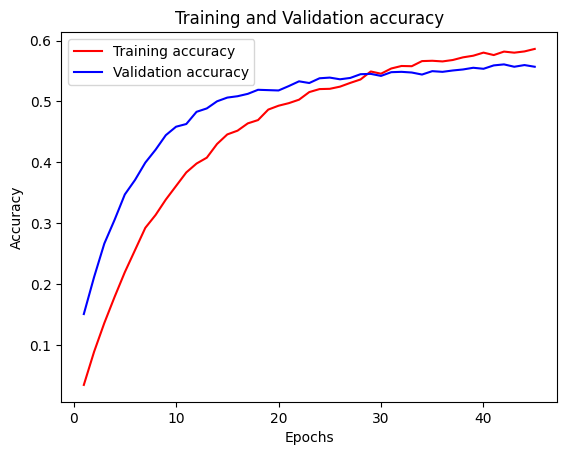

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=45, train_acc=acc_train, val_acc=acc_val)

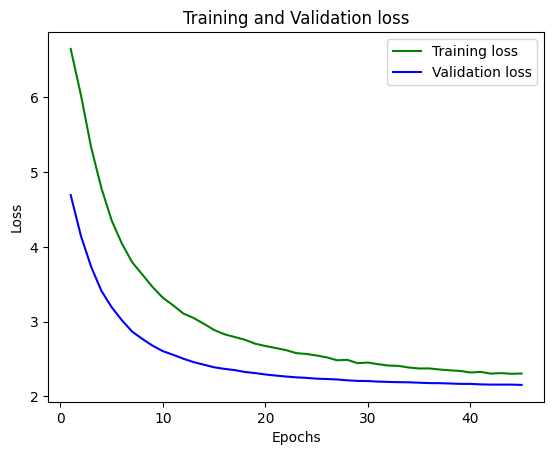

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plot_model_loss(num_epochs=45, train_loss=loss_train, val_loss=loss_val)

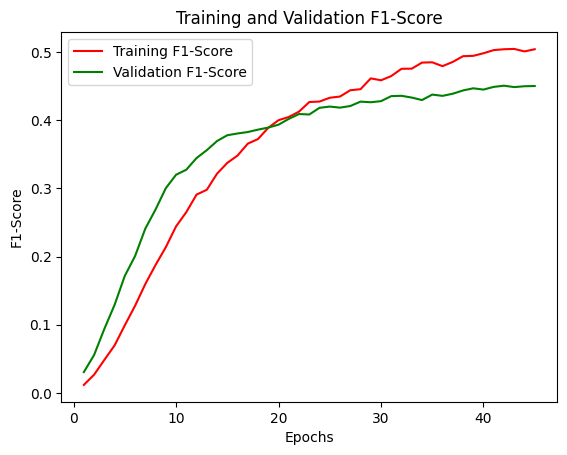

In [ ]:
x_axis = range(1,45+1)
plt.plot(x_axis, history.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [ ]:
experiment.model.save("resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras")

In [ ]:
from keras.models import load_model

# Carrega o modelo previamente guardado
model2 = load_model("resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras")

experiment2 = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_until_65",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
     lr_callback]

In [ ]:
history2 = experiment2.run_experiment(
    epochs=20,  
    callbacks=callbacks_additional, resume=True
)

No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5810 - auc: 0.7712 - f1_score: 0.4722 - loss: 2.3217

2025-04-15 19:35:28.157754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 134s 381ms/step


2025-04-15 19:37:43.009145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 331s 946ms/step - accuracy: 0.5810 - auc: 0.7712 - f1_score: 0.4723 - loss: 2.3216 - val_accuracy: 0.5593 - val_auc: 0.9556 - val_f1_score: 0.4492 - val_loss: 2.1514 - learning_rate: 1.1482e-05
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5806 - auc: 0.7723 - f1_score: 0.4717 - loss: 2.3227

2025-04-15 19:40:49.169433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 109s 310ms/step


2025-04-15 19:42:38.879604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 294s 820ms/step - accuracy: 0.5806 - auc: 0.7723 - f1_score: 0.4718 - loss: 2.3226 - val_accuracy: 0.5598 - val_auc: 0.9561 - val_f1_score: 0.4516 - val_loss: 2.1508 - learning_rate: 1.0965e-05
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.5861 - auc: 0.7734 - f1_score: 0.4781 - loss: 2.3026

2025-04-15 19:45:36.970237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 113s 323ms/step


2025-04-15 19:47:31.028482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 292s 835ms/step - accuracy: 0.5861 - auc: 0.7734 - f1_score: 0.4781 - loss: 2.3025 - val_accuracy: 0.5593 - val_auc: 0.9561 - val_f1_score: 0.4519 - val_loss: 2.1494 - learning_rate: 1.0471e-05
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.5846 - auc: 0.7715 - f1_score: 0.4760 - loss: 2.3090

2025-04-15 19:50:28.617543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 118s 336ms/step


2025-04-15 19:52:27.535714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 297s 849ms/step - accuracy: 0.5846 - auc: 0.7714 - f1_score: 0.4761 - loss: 2.3090 - val_accuracy: 0.5570 - val_auc: 0.9556 - val_f1_score: 0.4492 - val_loss: 2.1483 - learning_rate: 1.0000e-05
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5953 - auc: 0.7734 - f1_score: 0.4785 - loss: 2.2749

2025-04-15 19:55:32.245718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 356ms/step


2025-04-15 19:57:38.555174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 284ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 318s 909ms/step - accuracy: 0.5953 - auc: 0.7734 - f1_score: 0.4786 - loss: 2.2749 - val_accuracy: 0.5615 - val_auc: 0.9561 - val_f1_score: 0.4527 - val_loss: 2.1454 - learning_rate: 9.5499e-06
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5864 - auc: 0.7714 - f1_score: 0.4788 - loss: 2.2948

2025-04-15 20:00:52.574639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 116s 331ms/step


2025-04-15 20:02:48.903341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 303s 866ms/step - accuracy: 0.5864 - auc: 0.7714 - f1_score: 0.4790 - loss: 2.2947 - val_accuracy: 0.5587 - val_auc: 0.9559 - val_f1_score: 0.4524 - val_loss: 2.1442 - learning_rate: 9.1201e-06
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.5913 - auc: 0.7738 - f1_score: 0.4838 - loss: 2.2989

2025-04-15 20:05:49.869734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 121s 346ms/step


2025-04-15 20:07:52.017458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 300ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 307s 879ms/step - accuracy: 0.5913 - auc: 0.7737 - f1_score: 0.4839 - loss: 2.2988 - val_accuracy: 0.5576 - val_auc: 0.9562 - val_f1_score: 0.4504 - val_loss: 2.1426 - learning_rate: 8.7096e-06
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5939 - auc: 0.7730 - f1_score: 0.4838 - loss: 2.2830

2025-04-15 20:11:01.268591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 118s 337ms/step


2025-04-15 20:13:00.065562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 304s 867ms/step - accuracy: 0.5939 - auc: 0.7730 - f1_score: 0.4838 - loss: 2.2830 - val_accuracy: 0.5598 - val_auc: 0.9560 - val_f1_score: 0.4499 - val_loss: 2.1408 - learning_rate: 8.3176e-06
Epoch 9/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5881 - auc: 0.7736 - f1_score: 0.4823 - loss: 2.2721

2025-04-15 20:16:06.055761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 120s 342ms/step


2025-04-15 20:18:06.577746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 306s 875ms/step - accuracy: 0.5881 - auc: 0.7736 - f1_score: 0.4824 - loss: 2.2720 - val_accuracy: 0.5587 - val_auc: 0.9563 - val_f1_score: 0.4511 - val_loss: 2.1419 - learning_rate: 7.9433e-06
Epoch 10/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.5931 - auc: 0.7726 - f1_score: 0.4860 - loss: 2.2733

2025-04-15 20:21:16.288266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 123s 352ms/step


2025-04-15 20:23:20.253834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 312ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 318s 908ms/step - accuracy: 0.5932 - auc: 0.7726 - f1_score: 0.4861 - loss: 2.2733 - val_accuracy: 0.5582 - val_auc: 0.9566 - val_f1_score: 0.4496 - val_loss: 2.1399 - learning_rate: 7.5858e-06
Epoch 11/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.5941 - auc: 0.7732 - f1_score: 0.4853 - loss: 2.2675

2025-04-15 20:26:34.707352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 124s 354ms/step


2025-04-15 20:28:39.618418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 285ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 317s 904ms/step - accuracy: 0.5941 - auc: 0.7732 - f1_score: 0.4854 - loss: 2.2675 - val_accuracy: 0.5604 - val_auc: 0.9566 - val_f1_score: 0.4511 - val_loss: 2.1384 - learning_rate: 7.2444e-06
Epoch 12/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6003 - auc: 0.7738 - f1_score: 0.4907 - loss: 2.2782

2025-04-15 20:31:52.370303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 127s 361ms/step


2025-04-15 20:33:59.551889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 320s 916ms/step - accuracy: 0.6003 - auc: 0.7738 - f1_score: 0.4908 - loss: 2.2782 - val_accuracy: 0.5609 - val_auc: 0.9561 - val_f1_score: 0.4521 - val_loss: 2.1383 - learning_rate: 6.9183e-06
Epoch 13/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.5965 - auc: 0.7738 - f1_score: 0.4826 - loss: 2.2601

2025-04-15 20:37:15.650996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 127s 363ms/step


2025-04-15 20:39:23.725944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 324s 926ms/step - accuracy: 0.5965 - auc: 0.7738 - f1_score: 0.4827 - loss: 2.2601 - val_accuracy: 0.5609 - val_auc: 0.9564 - val_f1_score: 0.4521 - val_loss: 2.1367 - learning_rate: 6.6069e-06
Epoch 14/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5904 - auc: 0.7725 - f1_score: 0.4894 - loss: 2.2768

2025-04-15 20:42:39.928918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 355ms/step


2025-04-15 20:44:45.318734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 322s 920ms/step - accuracy: 0.5904 - auc: 0.7725 - f1_score: 0.4895 - loss: 2.2768 - val_accuracy: 0.5648 - val_auc: 0.9558 - val_f1_score: 0.4573 - val_loss: 2.1360 - learning_rate: 6.3096e-06
Epoch 15/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6015 - auc: 0.7751 - f1_score: 0.4944 - loss: 2.2454

2025-04-15 20:47:58.636015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 357ms/step


2025-04-15 20:50:04.427163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 295ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 319s 911ms/step - accuracy: 0.6015 - auc: 0.7751 - f1_score: 0.4945 - loss: 2.2454 - val_accuracy: 0.5626 - val_auc: 0.9564 - val_f1_score: 0.4569 - val_loss: 2.1355 - learning_rate: 6.0256e-06
Epoch 16/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6005 - auc: 0.7748 - f1_score: 0.4946 - loss: 2.2486

2025-04-15 20:53:17.481299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 360ms/step


2025-04-15 20:55:24.281038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 320s 915ms/step - accuracy: 0.6005 - auc: 0.7748 - f1_score: 0.4947 - loss: 2.2486 - val_accuracy: 0.5637 - val_auc: 0.9564 - val_f1_score: 0.4578 - val_loss: 2.1342 - learning_rate: 5.7544e-06
Epoch 17/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.5933 - auc: 0.7729 - f1_score: 0.4854 - loss: 2.2707

2025-04-15 20:58:43.082722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 124s 354ms/step


2025-04-15 21:00:47.777457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 323s 922ms/step - accuracy: 0.5933 - auc: 0.7729 - f1_score: 0.4855 - loss: 2.2706 - val_accuracy: 0.5637 - val_auc: 0.9561 - val_f1_score: 0.4608 - val_loss: 2.1343 - learning_rate: 5.4954e-06
Epoch 18/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.6000 - auc: 0.7753 - f1_score: 0.4905 - loss: 2.2556

2025-04-15 21:04:01.200619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 128s 364ms/step


2025-04-15 21:06:09.467737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 323s 923ms/step - accuracy: 0.6000 - auc: 0.7753 - f1_score: 0.4906 - loss: 2.2555 - val_accuracy: 0.5637 - val_auc: 0.9561 - val_f1_score: 0.4623 - val_loss: 2.1326 - learning_rate: 5.2481e-06
Epoch 19/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.5982 - auc: 0.7745 - f1_score: 0.4918 - loss: 2.2456

2025-04-15 21:09:27.017502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 355ms/step


2025-04-15 21:11:32.191721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 293ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 322s 921ms/step - accuracy: 0.5983 - auc: 0.7745 - f1_score: 0.4919 - loss: 2.2456 - val_accuracy: 0.5648 - val_auc: 0.9561 - val_f1_score: 0.4628 - val_loss: 2.1323 - learning_rate: 5.0119e-06
Epoch 20/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.6040 - auc: 0.7754 - f1_score: 0.4918 - loss: 2.2374

2025-04-15 21:14:47.701224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 123s 351ms/step


2025-04-15 21:16:51.482882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 285ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 319s 913ms/step - accuracy: 0.6040 - auc: 0.7753 - f1_score: 0.4919 - loss: 2.2374 - val_accuracy: 0.5632 - val_auc: 0.9561 - val_f1_score: 0.4588 - val_loss: 2.1319 - learning_rate: 4.7863e-06


In [ ]:
def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history:
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

combined_history = combine_histories(history, history2)

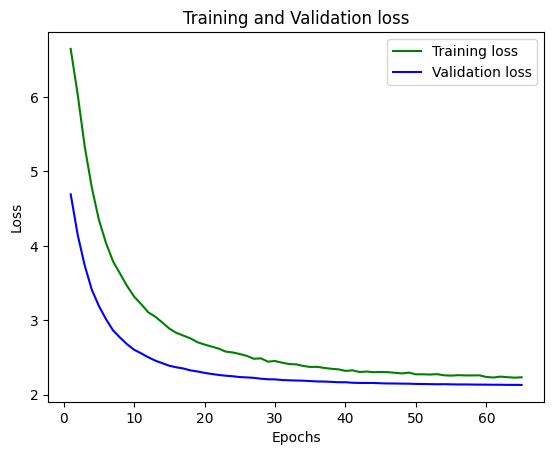

In [ ]:
loss_train = combined_history['loss']
loss_val = combined_history['val_loss']
plot_model_loss(num_epochs=len(loss_train), train_loss=loss_train, val_loss=loss_val)

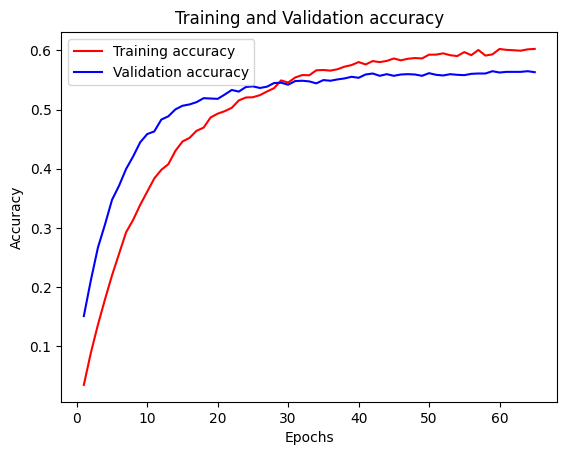

In [ ]:
acc_train = combined_history['accuracy']
acc_val = combined_history['val_accuracy']
plot_model_acc(num_epochs=65, train_acc=acc_train, val_acc=acc_val)

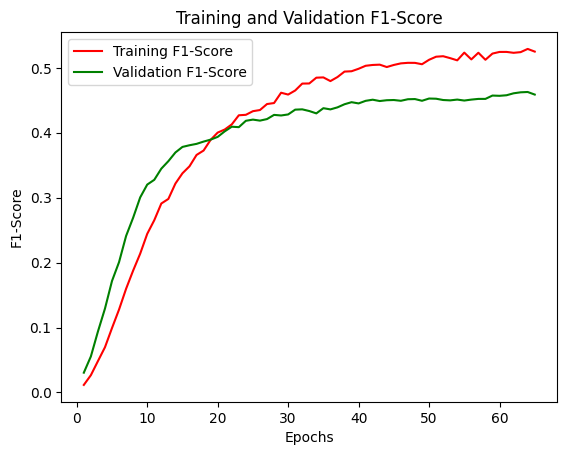

In [ ]:
x_axis = range(1,65+1)
plt.plot(x_axis, combined_history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, combined_history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [ ]:
experiment.model.save("resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_until_65.h5")

### Fine-tune

References: https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=pt-br

In [ ]:
model_ft = load_model("resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_until_65.keras", compile=False)

In [ ]:
trainable = False
for layer in model_ft.layers:
    if "conv5_block1_1_conv" in layer.name:
        trainable = True
    layer.trainable = trainable

model_ft.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

In [ ]:
experiment = Experiment(
    model=model_ft,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_finetuning_phase_v2",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_finetune = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]
    
# Run the experiment
history_finetune = history = experiment.run_experiment(callbacks=callbacks_additional, epochs=15)

No checkpoint found, starting from scratch.
Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.5676 - auc: 0.7717 - f1_score: 0.4523 - loss: 2.3972

2025-04-15 21:50:12.540146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 140s 389ms/step


2025-04-15 21:52:34.239698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 279ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 352s 987ms/step - accuracy: 0.5675 - auc: 0.7717 - f1_score: 0.4523 - loss: 2.3974 - val_accuracy: 0.5582 - val_auc: 0.9557 - val_f1_score: 0.4552 - val_loss: 2.0267 - learning_rate: 9.5499e-06
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.6191 - auc: 0.7738 - f1_score: 0.5066 - loss: 2.1776

2025-04-15 21:56:38.307295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 118s 337ms/step


2025-04-15 21:58:37.486777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.6191 - auc: 0.7738 - f1_score: 0.5067 - loss: 2.1777 - val_accuracy: 0.5698 - val_auc: 0.9564 - val_f1_score: 0.4686 - val_loss: 1.9861 - learning_rate: 9.1201e-06
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.6494 - auc: 0.7774 - f1_score: 0.5321 - loss: 2.0448

2025-04-15 22:03:07.725312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 86/350 ━━━━━━━━━━━━━━━━━━━━ 1:46 403ms/step

It's already overfiting. Lets do hyperband tuner in this fine tuning phase.

### Fine tune with hyperband tuner

In [13]:
# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment='mixup',
    oversampling=True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [14]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [15]:
model_ft = load_model("/Users/margaridabravocardoso/Documents/GitHub/deep-learning-project/project/project/resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_until_65.h5", compile=False)

In [16]:
len(model_ft.layers)

179

In [ ]:
import keras_tuner as kt

In [21]:
def model_builder(hp):
    model_ft = load_model("/Users/margaridabravocardoso/Documents/GitHub/deep-learning-project/project/project/resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_until_65.h5", compile=False)
    number_layers_unfreeze = hp.Int('number_layers_unfreeze', min_value = 5, max_value=50, step=5)

    trainable = False
    for layer in model_ft.layers:
        layer.trainable = trainable

    if number_layers_unfreeze>0:
        for layer in model_ft.layers[-number_layers_unfreeze:]:
            layer.trainable = True

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])

    model_ft.compile(optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
                    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=metrics)

    return model_ft

In [22]:
tuner = kt.Hyperband(
    hypermodel=model_builder,
    objective=kt.Objective("val_loss", direction="min"),  # ou "val_f1_score", direction="max"
    max_epochs=45,
    factor=3,
    hyperband_iterations=1,
    seed=42,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    directory='project/project',
    project_name='hyperband_finetune_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_until_65'
)

In [ ]:
callbacks = [EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)]

In [ ]:
tuner.search(
    x=train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

## EfficientNet

In [55]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

#initial_lr = 1e-4  
#final_lr = 1e-5
n_epochs = 50
#my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run2.csv",
#   lr_scheduler=my_scheduler_fn
)

In [56]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Número de classes (families) — substitui com o teu número real
num_classes = len(df['family'].unique())

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

# congela só as primeiras camadas
for layer in base_model.layers[:150]:
    layer.trainable = False

# Topo personalizado
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(202, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

# Compilar
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=metrics)

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("checkpoints/model.keras", monitor='val_loss', save_best_only=True),
    CSVLogger("logs/run2.csv")
]

In [58]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


KeyboardInterrupt: 

## VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input 

In [ ]:
# Load datasets
train_ds_vgg16, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment='mixup',
    oversampling=True,
    preprocessing_function=preprocess_input)

val_ds_vgg16, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
verbose = 1

metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)

In [ ]:
input_img = Input(shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)

In [ ]:
experiment = Experiment(
    model=model,
    train_ds= train_ds_vgg16,
    val_ds=val_ds_vgg16,
    experiment_name="vgg16_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,           # Reduce LR if no improvement after 2 epochs
        min_lr=1e-6,
        verbose=1
    )]


In [ ]:
history = experiment.run_experiment(callbacks=callbacks_additional, epochs=100)

No checkpoint found, starting from scratch.
Epoch 1/45


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
2025-04-15 22:39:01.185387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


350/350 ━━━━━━━━━━━━━━━━━━━━ 228s 641ms/step - accuracy: 0.0108 - auc: 0.5073 - f1_score: 0.0052 - loss: 17.9496 - val_accuracy: 0.0796 - val_auc: 0.5971 - val_f1_score: 0.0214 - val_loss: 9.7993 - learning_rate: 1.0000e-04
Epoch 2/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 257s 733ms/step - accuracy: 0.0309 - auc: 0.5226 - f1_score: 0.0127 - loss: 17.8888 - val_accuracy: 0.1358 - val_auc: 0.6390 - val_f1_score: 0.0312 - val_loss: 8.8385 - learning_rate: 1.0000e-04
Epoch 3/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 262s 749ms/step - accuracy: 0.0390 - auc: 0.5281 - f1_score: 0.0150 - loss: 18.0017 - val_accuracy: 0.1708 - val_auc: 0.6623 - val_f1_score: 0.0428 - val_loss: 8.2642 - learning_rate: 1.0000e-04
Epoch 4/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 249s 711ms/step - accuracy: 0.0530 - auc: 0.5344 - f1_score: 0.0211 - loss: 17.1141 - val_accuracy: 0.1942 - val_auc: 0.6847 - val_f1_score: 0.0518 - val_loss: 7.6041 - learning_rate: 1.0000e-04
Epoch 5/45
350/350 ━━━━━━━━━━━━━━━━━━━━ 248s 709ms/step - accuracy: 0.0